In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Initialization of Neural Network Parameters

When it comes to deep neural nets, you should be careful about how you initialize the weights. Bad initialization can lead from not learning at all to vanishing/exploding gradients.
Let's demonstrate this with our trivial example.

In [2]:
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)

# Generate some synthetic data
N = 1_000
X = jrandom.normal(key, (N,))
key, subkey = jrandom.split(key)
y = 1.5 * X ** 2 - 2 * X + jrandom.normal(subkey, (N,)) * 0.5

# Make also a test set (here an ideal one)
N_test = 50
X_test = jnp.linspace(-3, 3, N_test)
key, subkey = jrandom.split(key)
y_test = 1.5 * X_test ** 2 - 2 * X_test + jrandom.normal(subkey, (N_test,)) * 0.5

import numpy as np
import equinox as eqx
import jax
import optax
from functools import partial

    
# The function below generates batches of data
def data_generator(X, y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

# This is the loss function
def loss(model, x, y):
    y_pred = model(x)
    return optax.l2_loss(y_pred, y).mean()

# This is the training loop
def train_batch(
        model,
        x, y,
        optimizer,
        x_test, y_test,
        n_batch=10,
        n_epochs=10,
        freq=1,
    ):

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(model)
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    # The path of the test accuracy
    test_losses = []
    for e in range(n_epochs):
        for i, (xb, yb) in enumerate(data_generator(x, y, n_batch)):
            model, opt_state, value = step(opt_state, model, xb, yb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                test_losses.append(loss(model, x_test, y_test))
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {test_losses[-1]:.3f}")
    return model, path, losses, test_losses

This time we are going to make the model a proper neural network. Let's go with 3 hidden layers with 10 neurons each. We will use ReLU activation function for the hidden layers.

In [3]:
class NeuralNetwork(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(1, 10, key=key1),
            eqx.nn.Linear(10, 10, key=key2),
            eqx.nn.Linear(10, 1, key=key3)
        ]
    
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

The code above actually initializes the weights the correct way. We will talk about it in a while.
For now, let's start with a stupid choice.
First, set all the weights and biases to the same number, say zero.
Recall that Jax models are immutable, so we need to create a new model.

In [4]:
key, subkey = jrandom.split(key)

model = NeuralNetwork(subkey)

# Set all weights and biases to zero
zero_model = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), model)

# Confirm that everything is set to zero
jax.tree_util.tree_leaves(zero_model)


[Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 Array([0.], dtype=float32)]

Let's now demonstrate that this model cannot learn because most of the gradients are zero:

In [5]:
from jax import jit, grad

grad_loss = jit(grad(loss))

g = grad_loss(zero_model, X[:, None], y[:, None])

jax.tree_util.tree_leaves(g)

[Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 Array([-1.4736239], dtype=float32)]

Why does this happen? The reason here is the the relu function. Recall that relu is defined as:

$$
\text{relu}(x) = \max(0, x)
$$

So, if the input is negative, the gradient is zero. This is called the dying relu problem. If the input is negative, the gradient is zero and the weights are not updated. This is why the model cannot learn.

The same thing happens in other activation functions if we are not careful. For example, in sigmoid, if the input is too large or too small, the gradient is also zero. We say that the gradients are saturated.

Okay, let's shift all weights and biases by a bit so that relu is not saturated anymore.
We can achieve this by adding a small number, say 0.1, to everything:

In [7]:
new_model = jax.tree_util.tree_map(lambda x: 0.1 * jnp.ones_like(x), model)
jax.tree_util.tree_leaves(new_model)


[Array([[0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1]], dtype=float32),
 Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32),
 Array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32),
 Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32),
 Array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype

Let's see what the gradients are now:

In [8]:
g = grad_loss(new_model, X[:, None], y[:, None])

jax.tree_util.tree_leaves(g)

[Array([[0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982],
        [0.02420982]], dtype=float32),
 Array([-0.01698821, -0.01698821, -0.01698821, -0.01698821, -0.01698821,
        -0.01698821, -0.01698821, -0.01698821, -0.01698821, -0.01698821],      dtype=float32),
 Array([[0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216,
         0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216],
        [0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216,
         0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216],
        [0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216,
         0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216],
        [0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216,
         0.00072216, 0.00072216, 0.00072216, 0.00072216, 0.00072216],
        [0.00072216, 0.00072216, 0.0007

Now get non-zero gradients, but we have another problem.
Pay attention to the gradients for the weight of a given layer. They are all the same!
This is not good. The model will move all the weights in the same direction, which is not what we want.
It will never learn anything useful.
This is called the symmetry problem.
We need to initialize the parameters in a way that breaks the symmetry.

## Xavier or Glorot initialization

The Xavier (or Glorot) initialization was introduced in the paper [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by Xavier Glorot and Yoshua Bengio.
The method initializes the weights of a layer with a uniform distribution in the range $[-a, a]$ with $a$ being:

$$
a = \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}
$$

where $n_{\text{in}}$ is the number of inputs to the layer and $n_{\text{out}}$ is the number of outputs from the layer.
The weights are initialized by:

$$
w_{ij} \sim \mathcal{U}([-a, a]).
$$

The biases are initialized to zero or to a small positive number (if the activation function is ReLU).

Here is how we can do this in Jax:

In [9]:
def random_weight(key, shape, lim):
    return jrandom.uniform(key, shape, minval=-lim, maxval=lim)


xavier_model = model
for i in range(3):
    # Initialize the weight for layer i
    key, subkey = jrandom.split(key)
    shape = xavier_model.layers[i].weight.shape
    xavier_model = eqx.tree_at(
        lambda m: m.layers[i].weight,
        xavier_model,
        random_weight(
            subkey,
            shape,
            jnp.sqrt(6 / (shape[0] + shape[1]))
        ),
    )
    # Set the bias to 0.1
    xavier_model = eqx.tree_at(
        lambda m: m.layers[i].bias,
        xavier_model,
        0.1 * jnp.ones_like(xavier_model.layers[i].bias),
    )

jax.tree_util.tree_leaves(xavier_model)

[Array([[ 0.32371843],
        [-0.09270354],
        [ 0.6612312 ],
        [-0.6682776 ],
        [-0.24418366],
        [-0.37407488],
        [-0.25916752],
        [ 0.5819582 ],
        [-0.15898605],
        [-0.3486244 ]], dtype=float32),
 Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32),
 Array([[ 0.3676433 ,  0.37487116,  0.08109037,  0.03349315, -0.16421711,
         -0.36349794, -0.07435115, -0.44226253,  0.18982252,  0.5187848 ],
        [-0.5399611 , -0.37376797,  0.27842256,  0.12041358, -0.33761817,
         -0.22923872,  0.3782641 ,  0.3010011 ,  0.20852078,  0.3341495 ],
        [-0.29488283,  0.40181315,  0.06843881,  0.1779477 ,  0.12430247,
          0.34012973,  0.41524926,  0.30109957,  0.02873337, -0.1421873 ],
        [ 0.08526394,  0.03162144,  0.14541529, -0.29462987,  0.456133  ,
          0.42672893,  0.23817806, -0.22955617, -0.28543863, -0.27825502],
        [-0.00537615, -0.46676868,  0.15361108,  0.2696966 , -0.3681953 ,
        

Test the gradients:

In [10]:
g = grad_loss(xavier_model, X[:, None], y[:, None])

jax.tree_util.tree_leaves(g)

[Array([[ 0.02699523],
        [ 0.37146565],
        [-0.02454231],
        [ 0.18399827],
        [ 1.2244885 ],
        [ 0.76599014],
        [ 0.69746107],
        [ 0.00779888],
        [-0.53853697],
        [-1.0709085 ]], dtype=float32),
 Array([-0.09308025, -0.20425463,  0.03026273, -0.11606807, -0.7400332 ,
        -0.4753357 , -0.42907578,  0.03981695,  0.2839816 ,  0.6556119 ],      dtype=float32),
 Array([[-1.53877772e-02,  5.92427403e-02, -2.56949235e-02,
          2.88320154e-01,  1.20761983e-01,  1.72247618e-01,
          1.26719296e-01, -2.32813507e-02,  8.65963027e-02,
          1.62184060e-01],
        [ 1.10576606e-04,  2.97773862e-03,  4.12342313e-04,
          1.44919343e-02,  6.06990140e-03,  8.65774229e-03,
          6.36933604e-03,  3.41097708e-04,  4.35262080e-03,
          8.15191399e-03],
        [ 5.06376964e-04,  1.36363255e-02,  1.88829028e-03,
          6.63647130e-02,  2.77966522e-02,  3.96474712e-02,
          2.91678905e-02,  1.56203099e-03,  1.99324

Another thing that is commonly done is to look at the histogram of the gradient of all parameters:

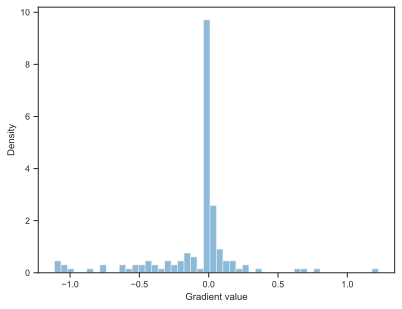

In [11]:
all_grads = jnp.hstack(
    jax.tree_util.tree_map(
        lambda p: p.flatten(),
        jax.tree_util.tree_leaves(g)
    )
)
fig, ax = plt.subplots()
ax.hist(all_grads, bins=50, density=True, alpha=0.5)
ax.set(xlabel="Gradient value", ylabel="Density");


It looks better than before, but it is not perfect.
The reason is that Xavier initialization has been designed for sigmoid and tanh activation functions.
For ReLU, we need to use a different initialization.

## He initialization

The He initialization was introduced in the paper [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun.
The method initializes the weights of a layer with a uniform distribution in the range $[-a, a]$ with $a$ being:

$$
a = \sqrt{\frac{1}{n_{\text{in}}}}
$$

where $n_{\text{in}}$ is the number of inputs to the layer.
This is the default initialization used in `equinox.nn.Linear`.
Let's see how it works:

In [12]:
g = grad_loss(model, X[:, None], y[:, None])
jax.tree_util.tree_leaves(g)

[Array([[-0.137161  ],
        [-0.14594285],
        [ 0.1972345 ],
        [-0.05604376],
        [-0.0023809 ],
        [ 0.00070995],
        [ 0.36193305],
        [ 0.00602406],
        [-0.01431112],
        [ 0.        ]], dtype=float32),
 Array([ 0.09015069,  0.12984118, -0.13102864,  0.05271221, -0.00669131,
        -0.00057694, -0.22451383,  0.00280493, -0.00255928,  0.        ],      dtype=float32),
 Array([[ 1.0778138e-02,  1.2327660e-02,  8.2478148e-04,  1.7101418e-02,
          2.3551367e-02,  2.0171790e-03,  5.2287388e-03,  2.0648468e-02,
          2.0914447e-02,  0.0000000e+00],
        [ 0.0000000e+00, -2.7174037e-03,  0.0000000e+00, -2.0803507e-02,
         -3.9404470e-02, -2.9371942e-03,  1.6780789e-03, -2.9066479e-02,
         -3.0834939e-02,  0.0000000e+00],
        [-1.3764948e-01, -1.4081910e-01, -5.5947408e-02, -4.5996405e-02,
         -1.1695730e-02, -8.3952531e-04, -8.1302613e-02, -8.0701225e-03,
         -8.8563329e-03,  0.0000000e+00],
        [-4.8459396e-

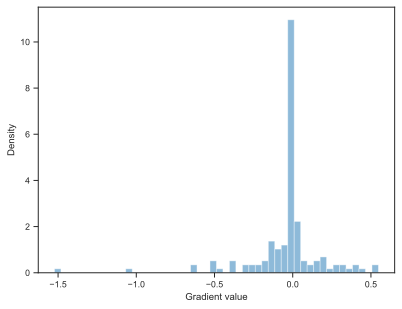

In [13]:
all_grads = jnp.hstack(
    jax.tree_util.tree_map(
        lambda p: p.flatten(),
        jax.tree_util.tree_leaves(g)
    )
)
fig, ax = plt.subplots()
ax.hist(all_grads, bins=50, density=True, alpha=0.5)
ax.set(xlabel="Gradient value", ylabel="Density");

It looks better because the gradients are more spread out.

You should use He initialization for ReLU and Xavier initialization for sigmoid and tanh.
You should prefer He initialization for deeper networks.
But at the end of the day, these are just rules of thumb.
You should always look at your gradients histograms and make sure that they are not too peaked at zero.

Let's finish up by seeing how our network can learn:

In [14]:
model, path, losses, test_losses = train_batch(
    model,
    X[:, None], y[:, None],
    optax.adam(0.01),
    X_test[:, None], y_test[:, None],
    n_batch=100,
    n_epochs=100,
    freq=10,
)

Epoch 0, step 0, loss 4.046, test 26.340
Epoch 1, step 0, loss 2.562, test 20.785
Epoch 2, step 0, loss 2.682, test 14.236
Epoch 3, step 0, loss 3.412, test 8.201
Epoch 4, step 0, loss 0.886, test 5.213
Epoch 5, step 0, loss 0.531, test 2.700
Epoch 6, step 0, loss 0.367, test 1.592
Epoch 7, step 0, loss 0.277, test 1.419
Epoch 8, step 0, loss 0.219, test 1.221
Epoch 9, step 0, loss 0.214, test 1.027
Epoch 10, step 0, loss 0.200, test 0.797
Epoch 11, step 0, loss 0.174, test 0.584
Epoch 12, step 0, loss 0.201, test 0.477
Epoch 13, step 0, loss 0.166, test 0.366
Epoch 14, step 0, loss 0.315, test 0.341
Epoch 15, step 0, loss 0.202, test 0.348
Epoch 16, step 0, loss 0.186, test 0.315
Epoch 17, step 0, loss 0.169, test 0.294
Epoch 18, step 0, loss 0.139, test 0.317
Epoch 19, step 0, loss 0.156, test 0.237
Epoch 20, step 0, loss 0.252, test 0.215
Epoch 21, step 0, loss 0.294, test 0.245
Epoch 22, step 0, loss 0.167, test 0.210
Epoch 23, step 0, loss 0.214, test 0.220
Epoch 24, step 0, loss 

Here is the evolution of the loss:

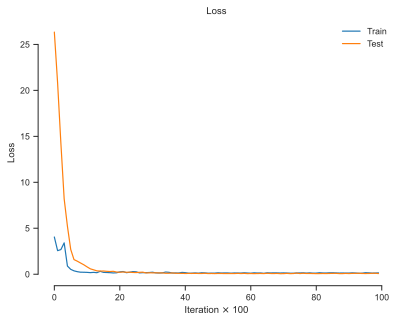

In [15]:
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's make some predictions:

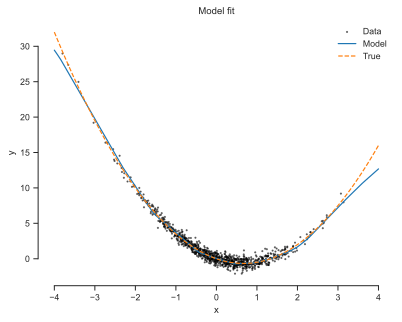

In [16]:
xs = jnp.linspace(-4, 4, 100)
fig, ax = plt.subplots()
ax.scatter(X, y, color='black', label="Data", alpha=0.5, s=2)
ax.plot(xs, model(xs[:, None]).flatten(), label="Model")
ax.plot(xs, 1.5 * xs ** 2 - 2 * xs, '--', label="True")
ax.set(xlabel="x", ylabel="y", title="Model fit")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

The fit looks good. It is not perfect because we are using a stupid model (we should have used a simple polynomial regression), but it is good enough to demonstrate the basic concepts.